In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=10
✅ 시뮬레이션 초기화 완료: S=10, Randomness='high', M1=758.40, M2=1855.82


In [27]:
set= gp.Model("set")
# set.setParam("MIPGap", 1e-7)

x = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="x")  # x_{it}
yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_discharge")
z = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="z_soc")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
zeta = set.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = set.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
eta = set.addVars(T, S, vtype=GRB.BINARY, name="eta")
a = set.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
gc = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
g = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum((1 / S) * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s]) 
                for t in range(T) for s in range(S))
      
set.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    set.addConstr(a[t] == gp.quicksum(x[i, t, s] for i in range(I)))
    set.addConstr(bp[t, s] == gp.quicksum(ep[i, t, s] for i in range(I)))
    set.addConstr(bm[t, s] == gp.quicksum(em[i, t, s] for i in range(I)))
    set.addConstr(g[t, s] == gp.quicksum(z[i, t, s] for i in range(I)))
    set.addConstr(gc[t, s] == gp.quicksum(zc[i, t, s] for i in range(I)))
    set.addConstr(gd[t, s] == gp.quicksum(zd[i, t, s] for i in range(I)))
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) + gd[t, s] >= bp[t, s] + gc[t, s])
    set.addConstr(bm[t, s] <= M2 * eta[t, s])
    set.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    set.addConstr(g[t, s] <= sum(K))
    set.addConstr(g[t, s] >= 0)
    set.addConstr(g[t, s] >= gd[t, s])
for s in range(S):
    set.addConstr(g[0, s] == sum(K0) + gc[0, s] - gd[0, s])
    set.addConstr(gd[0, s] <= sum(K0))
for t, s in product(range(1, T), range(S)):
    set.addConstr(g[t, s] == g[t - 1, s] + gc[t, s] - gd[t, s])
    set.addConstr(gd[t, s] <= g[t - 1, s])


for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t, s] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(R[i, t, s] + zd[i, t, s] >= yp[i, t, s] + zc[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t, s] >= 0)
    set.addConstr(z[i, t, s] >= zd[i, t, s])

for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i] + zc[i, 0, s] - zd[i, 0, s])
    set.addConstr(zd[i, 0, s] <= K0[i])
for i, t, s in product(range(I), range(1, T), range(S)):
    set.addConstr(z[i, t, s] == z[i, t - 1, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(z[i, t-1, s] >= zd[i, t, s])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] + zd[i, t, s] - zc[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I) if j != i))
    set.addConstr(em[i, t, s] == ym[i, t, s] - zd[i, t, s] + zc[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I) if j != i))
    set.addConstr(gp.quicksum(d[i, j, t, s] for j in range(I) if j != i) <= yp[i, t, s] + zd[i, t, s] - zc[i, t, s])
    set.addConstr(gp.quicksum(d[j, i, t, s] for j in range(I) if j != i) <= ym[i, t, s] - zd[i, t, s] + zc[i, t, s])
    set.addConstr(d[i, i, t, s] == 0)
    
set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")

x_vals = np.array([[[x[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
a_vals  = np.array([a[t].X for t in range(T)])
bp_vals = np.array([[bp[t, s].X for s in range(S)] for t in range(T)])
bm_vals = np.array([[bm[t, s].X for s in range(S)] for t in range(T)])
g_vals  = np.array([[g[t, s].X  for s in range(S)] for t in range(T)])
gc_vals = np.array([[gc[t, s].X for s in range(S)] for t in range(T)])
gd_vals = np.array([[gd[t, s].X for s in range(S)] for t in range(T)])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 22800 rows, 19464 columns and 82200 nonzeros
Model fingerprint: 0x4409aab4
Variable types: 16824 continuous, 2640 integer (2640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 9620 rows and 3200 columns
Presolve time: 0.09s
Presolved: 13180 rows, 16264 columns, 52450 nonzeros
Variable types: 14614 continuous, 1650 integer (1650 binary)
Found heuristic solution: objective 1555352.6825

Root relaxation: cutoff, 9846 iterations, 0.20 seconds (0.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

In [28]:
da_profit = sum(P_DA[t] * a[t].X for t in range(T))
rt_profit = sum(P_RT[t, s] * bp[t, s].X / S for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * bm[t, s].X / S for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost
print("[SETTLEMENT MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[SETTLEMENT MODEL]
DA Profit      = 431530.01
RT Profit      = 1141444.28
Penalty Cost   = 17621.61
Total Profit   = 1555352.68



[SET MODEL] Day-Ahead Commitment (alpha values):
TOTAL: 2882.26


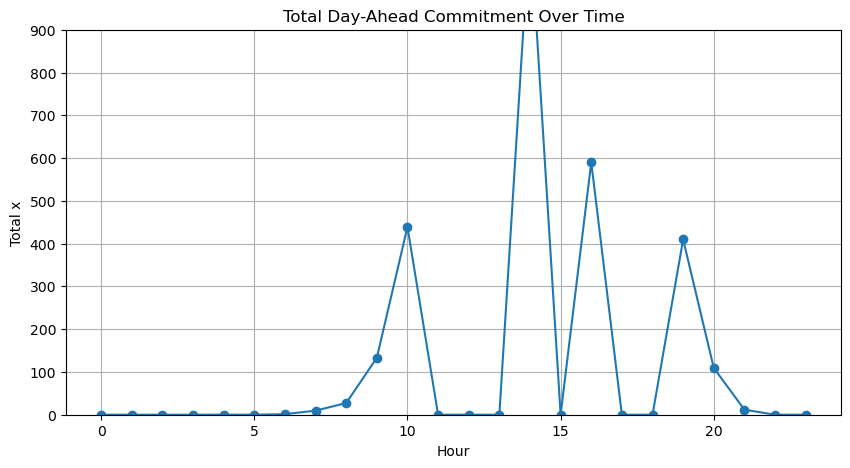

In [29]:
print("\n[SET MODEL] Day-Ahead Commitment (alpha values):")
total_agg_commit = 0
for t in range(T):
    alpha_t = a[t].X
    total_agg_commit += alpha_t
    # print(f"Time {t}: {alpha_t:.2f}")
print(f"TOTAL: {total_agg_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), a_vals, marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,900)
plt.grid(True)
plt.show()